In [1]:
# Env: dqn_roost as of 15/1/2022 (after addition of ROOST)
import numpy as np
import pickle5 as pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch, DCN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env_constrained import generate_random_act, ConstrainedMaterialEnvironment, extract_data_from_ep, generate_random_ep, predict_sinter
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.checkers import check_neutrality, check_neutrality, check_neutrality_multiple, check_electronegativity_multiple, check_both_multiple
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
from roost_models.roost_model import predict_formation_energy, predict_bulk_mod, predict_shear_mod, predict_band_gap
import json
from configs import configs
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print(torch.cuda.is_available())
from metrics import similarity_to_nearest_neighbor
import pandas as pd
from matplotlib import gridspec
import matplotlib

/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


True


# Formation energy task

In [2]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

KeyboardInterrupt: 

# Bulk modulus task

In [3]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_bulk_mod/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10399.03it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10640.20it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21227.57it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9255.37it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10307.47it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11365.38it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20665.26it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9277.20it/s]

Average Element Mover's distance: 7.5943
Std Element Mover's distance: 4.0024


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -0.5865680969462265,
 'form_e_trained_std': 0.43989970302957976,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 5.358326883792877,
 'bulk_mod_trained_std': 0.21379967833644037,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.853,
 'electronegativity_balanced_trained': 0.658,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 7.594290557421418,
 'final_compounds_EMD_std': 4.002392501670763}

# Shear modulus task

In [4]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_shear_mod/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Shear modulus
shear_mod_random = []
shear_mod_trained = []
for compound in random_oxides:
    shear_mod_random.append(predict_shear_mod(compound))
for compound in final_compounds:
    shear_mod_trained.append(predict_shear_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['shear_mod_random_mean'] = np.mean(shear_mod_random)
results['shear_mod_random_std'] = np.std(shear_mod_random)
results['shear_mod_trained_mean'] = np.mean(shear_mod_trained)
results['shear_mod_trained_std'] = np.std(shear_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10276.58it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10472.17it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21341.74it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9051.33it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10122.54it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10606.35it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20710.72it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9388.00it/s]

Average Element Mover's distance: 11.0803
Std Element Mover's distance: 5.09


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -1.0089453325352515,
 'form_e_trained_std': 0.5557614357089498,
 'shear_mod_random_mean': 3.6573499751091005,
 'shear_mod_random_std': 0.7215814376106682,
 'shear_mod_trained_mean': 4.462840408086777,
 'shear_mod_trained_std': 0.4064563218900934,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.828,
 'electronegativity_balanced_trained': 0.692,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 11.080325785915916,
 'final_compounds_EMD_std': 5.090006029103403}

# Sintering temp task

In [5]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter/final_compounds_RF_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in random_oxides:
    sintering_random.append(predict_sinter(compound))
for compound in final_compounds:
    sintering_trained.append(predict_sinter(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 9887.17it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10606.78it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21045.67it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9141.52it/s]

Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238



100%|██████████| 1000/1000 [00:00<00:00, 9773.77it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 999/999 [00:00<00:00, 10839.82it/s]


Constructing joint compositional pairings


100%|██████████| 998/998 [00:00<00:00, 20194.30it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/998 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 999/999 [00:00<00:00, 9266.89it/s]

Average Element Mover's distance: 12.1065
Std Element Mover's distance: 7.4308


{'form_e_random_mean': -1.3723867757171393,
 'form_e_random_std': 0.7347616402849283,
 'form_e_trained_mean': -1.0209875418955925,
 'form_e_trained_std': 0.5078395340291537,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 827.3537152992774,
 'sintering_trained_std': 98.18427515077079,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.857,
 'electronegativity_balanced_trained': 0.647,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 12.106459439126505,
 'final_compounds_EMD_std': 7.430761712579701}

# Formation energy + Bulk modulus (1:1)

In [6]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e_bulk_mod/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10310.94it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 11057.31it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21282.66it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9327.87it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10622.15it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10622.61it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20614.53it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9068.39it/s]

Average Element Mover's distance: 15.4826
Std Element Mover's distance: 6.8594


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -2.0647728165872397,
 'form_e_trained_std': 0.8399860098276903,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 4.605049775362015,
 'bulk_mod_trained_std': 0.4755187870794003,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.653,
 'electronegativity_balanced_trained': 0.602,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 15.482586450380376,
 'final_compounds_EMD_std': 6.859355433358803}

# Formation energy + Bulk modulus (1:2)

In [7]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e_bulk_mod_1-2/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10283.99it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10400.19it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20618.08it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9257.42it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10454.03it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10852.27it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20614.63it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9351.33it/s]

Average Element Mover's distance: 19.2648
Std Element Mover's distance: 9.3601


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -1.2955081553012133,
 'form_e_trained_std': 0.7871812820430854,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 4.7102729897499085,
 'bulk_mod_trained_std': 0.6149082531025668,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.785,
 'electronegativity_balanced_trained': 0.667,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 19.264828293489487,
 'final_compounds_EMD_std': 9.36010395686648}

# Formation energy + Bulk modulus (1:3)

In [8]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e_bulk_mod_1-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10063.86it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10340.48it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21073.19it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9142.54it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10211.06it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10830.80it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20863.24it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9133.36it/s]

Average Element Mover's distance: 10.9479
Std Element Mover's distance: 5.5133


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -1.0311186917519664,
 'form_e_trained_std': 0.5943204022273669,
 'bulk_mod_random_mean': 4.291398881912231,
 'bulk_mod_random_std': 0.6012997360124902,
 'bulk_mod_trained_mean': 5.012083717107773,
 'bulk_mod_trained_std': 0.5355028942943346,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.902,
 'electronegativity_balanced_trained': 0.78,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 10.94794918809209,
 'final_compounds_EMD_std': 5.513299101695085}

# Sintering temperature + Bulk modulus (1:62.5)

In [9]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter_bulk_mod_1-62/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in random_oxides:
    sintering_random.append(predict_sinter(compound))
for compound in final_compounds:
    sintering_trained.append(predict_sinter(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)

results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)

results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)

results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10288.53it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10365.78it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21193.53it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 8842.40it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 9814.70it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10037.92it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20437.86it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9294.79it/s]

Average Element Mover's distance: 11.155
Std Element Mover's distance: 6.2442


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.861684630729258,
 'form_e_trained_std': 0.48508761094613323,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 826.7920277303912,
 'sintering_trained_std': 103.82986867335417,
 'bulk_mod_random_mean': 4.291398871898651,
 'bulk_mod_random_std': 0.6012997253423198,
 'bulk_mod_trained_mean': 4.243075564146042,
 'bulk_mod_trained_std': 0.7744622749481933,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.859,
 'electronegativity_balanced_trained': 0.616,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 11.15498477787988,
 'final_compounds_EMD_std': 6.244239116801435}

# Sintering temperature + Bulk modulus (1:125)

In [10]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter_bulk_mod_1-125/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in random_oxides:
    sintering_random.append(predict_sinter(compound))
for compound in final_compounds:
    sintering_trained.append(predict_sinter(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)

results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)

results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)

results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10175.61it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10564.73it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 21232.41it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9067.41it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10155.04it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 999/999 [00:00<00:00, 10621.67it/s]


Constructing joint compositional pairings


100%|██████████| 998/998 [00:00<00:00, 20769.96it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/998 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 999/999 [00:00<00:00, 9387.58it/s]

Average Element Mover's distance: 10.1269
Std Element Mover's distance: 5.0021


{'form_e_random_mean': -1.3723867772072553,
 'form_e_random_std': 0.7347616385105727,
 'form_e_trained_mean': -0.7962676405527164,
 'form_e_trained_std': 0.4577622202616426,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 886.3413630313264,
 'sintering_trained_std': 102.12414943661948,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 4.735590208292008,
 'bulk_mod_trained_std': 0.6714195295146307,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.847,
 'electronegativity_balanced_trained': 0.628,
 'unique_random': 1.0,
 'unique_trained': 1.0,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 10.126934490973941,
 'final_compounds_EMD_std': 5.00210909851853}

# Sintering temperature + Bulk modulus (1:250)

In [11]:
# Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_sinter_bulk_mod_1-250/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Sintering temp
sintering_random = []
sintering_trained = []
for compound in random_oxides:
    sintering_random.append(predict_sinter(compound))
for compound in final_compounds:
    sintering_trained.append(predict_sinter(compound))

# Bulk modulus
bulk_mod_random = []
bulk_mod_trained = []
for compound in random_oxides:
    bulk_mod_random.append(predict_bulk_mod(compound))
for compound in final_compounds:
    bulk_mod_trained.append(predict_bulk_mod(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

# EMD
random_oxides_EMD_mean, random_oxides_EMD_std = similarity_to_nearest_neighbor(random_oxides)
final_compounds_EMD_mean, final_compounds_EMD_std = similarity_to_nearest_neighbor(final_compounds)

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)

results['sintering_random_mean'] = np.mean(sintering_random)
results['sintering_random_std'] = np.std(sintering_random)
results['sintering_trained_mean'] = np.mean(sintering_trained)
results['sintering_trained_std'] = np.std(sintering_trained)

results['bulk_mod_random_mean'] = np.mean(bulk_mod_random)
results['bulk_mod_random_std'] = np.std(bulk_mod_random)
results['bulk_mod_trained_mean'] = np.mean(bulk_mod_trained)
results['bulk_mod_trained_std'] = np.std(bulk_mod_trained)

results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results['random_oxides_EMD_mean'], results['random_oxides_EMD_std'] = random_oxides_EMD_mean, random_oxides_EMD_std
results['final_compounds_EMD_mean'], results['final_compounds_EMD_std'] = final_compounds_EMD_mean, final_compounds_EMD_std
results

100%|██████████| 1000/1000 [00:00<00:00, 10312.31it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 1000/1000 [00:00<00:00, 10133.54it/s]


Constructing joint compositional pairings


100%|██████████| 999/999 [00:00<00:00, 20795.31it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/999 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 1000/1000 [00:00<00:00, 9138.59it/s]


Average Element Mover's distance: 20.1286
Std Element Mover's distance: 9.8238


100%|██████████| 1000/1000 [00:00<00:00, 10437.82it/s]


Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████| 997/997 [00:00<00:00, 10886.50it/s]


Constructing joint compositional pairings


100%|██████████| 996/996 [00:00<00:00, 20515.28it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/996 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists


100%|██████████| 997/997 [00:00<00:00, 9439.85it/s]

Average Element Mover's distance: 8.878
Std Element Mover's distance: 4.4907


{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.43416797831025905,
 'form_e_trained_std': 0.35918108369723534,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 935.1747791413529,
 'sintering_trained_std': 64.0713517664827,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 5.226487160682678,
 'bulk_mod_trained_std': 0.36209249095798707,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.926,
 'electronegativity_balanced_trained': 0.639,
 'unique_random': 1.0,
 'unique_trained': 0.999,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 8.878022898180483,
 'final_compounds_EMD_std': 4.490652502172893}

In [12]:
results

{'form_e_random_mean': -1.3723867765516042,
 'form_e_random_std': 0.7347616392281606,
 'form_e_trained_mean': -0.43416797831025905,
 'form_e_trained_std': 0.35918108369723534,
 'sintering_random_mean': 1011.1405443517411,
 'sintering_random_std': 131.0925303880326,
 'sintering_trained_mean': 935.1747791413529,
 'sintering_trained_std': 64.0713517664827,
 'bulk_mod_random_mean': 4.29139886379242,
 'bulk_mod_random_std': 0.6012997229802703,
 'bulk_mod_trained_mean': 5.226487160682678,
 'bulk_mod_trained_std': 0.36209249095798707,
 'charge_neutral_random': 0.599,
 'electronegativity_balanced_random': 0.428,
 'charge_neutral_trained': 0.926,
 'electronegativity_balanced_trained': 0.639,
 'unique_random': 1.0,
 'unique_trained': 0.999,
 'random_oxides_EMD_mean': 20.128644743593593,
 'random_oxides_EMD_std': 9.82379022238823,
 'final_compounds_EMD_mean': 8.878022898180483,
 'final_compounds_EMD_std': 4.490652502172893}

# Joint Optimization Figure

In [3]:
# Load predicted formation energies of random oxides 
with open('./training_data/oxides_sinter_bulk_mod_1-62/sinter_random.pkl', 'rb') as f: 
    sinter_random = pickle.load(f)

# Load predicted bulk mod of random oxides 
with open('./training_data/oxides_sinter_bulk_mod_1-62/bulk_mod_random.pkl', 'rb') as f: 
    bulk_mod_random = pickle.load(f)

# Load predicted formation energies of constrained DQN
ratios = [
          '1-250',
          '1-125',
          '1-62'
          ]
sinter_dict   = {}
bulk_mod_dict = {}


for ratio in ratios:
    with open('./training_data/oxides_sinter_bulk_mod_{}/sinter_500iter_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        sinter_constrained = pickle.load(f)
        sinter_dict[ratio] = sinter_constrained

    # Load predicted bulk mod of constrained DQN
    with open('./training_data/oxides_sinter_bulk_mod_{}/bulk_mod_500iter_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        bulk_mod_constrained = pickle.load(f)
        bulk_mod_dict[ratio] = bulk_mod_constrained

# visualize compounds
# Load generated compounds of constrained DQN
compounds_dict   = {}

for ratio in ratios:
    with open('./training_data/oxides_sinter_bulk_mod_{}/final_compounds_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        compounds = pickle.load(f)
        compounds_dict[ratio] = compounds

880.6949242424243 5.514501571655273
Os5WO5 1-250


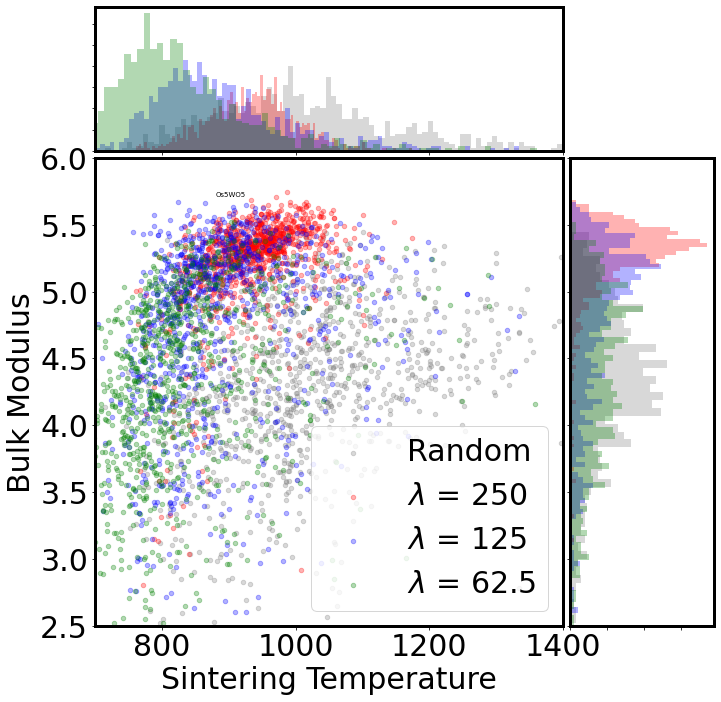

In [105]:
compounds_to_check = []
# 2D plot
# definitions for the axes
colors = ['red', 'blue', 'green']
alpha = 0.3
bins = 100

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)

ax.scatter(sinter_random, bulk_mod_random, alpha = 0.3, color = 'grey', s = 20, label = 'Random')
ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')

count = 0
for ratio in ratios:
    get_label = lambda x: x.split('-')[1] if (x in ['1-250','1-125']) else '62.5'
    label = get_label(ratio)
    ax.scatter(sinter_dict[ratio], bulk_mod_dict[ratio], color = colors[count], alpha = alpha, s = 20, label = '$\lambda$ = '+ label) 
    ax_histx.hist(sinter_dict[ratio], color = colors[count], alpha = 0.3, bins = bins)
    ax_histy.hist(bulk_mod_dict[ratio], color = colors[count], alpha = 0.3, bins = bins, orientation='horizontal')
    compounds = compounds_dict[ratio]
    
    count += 1

    # labels for compounds on pareto front
    pareto_threshold = 480
    x_weight, y_weight = ratio.split('-') # relative weights for two metrics
    x_weight, y_weight = float(x_weight), float(y_weight)
    for compound, x, y in zip(compounds, sinter_dict[ratio], bulk_mod_dict[ratio]):
        if -x_weight*x + y_weight*y > pareto_threshold: # plot if the combined metric is above a certain threshold
            compound = Composition(compound)
            compound = compound.reduced_formula 
            compounds_to_check.append(compound)
            if compound == 'Os5WO5':
                ax.text(x = x, y = y+0.2, s = compound, size = 7)
                print(x, y)
                print(compound, ratio)

ax.set_xlabel('Sintering Temperature', size = 30)
ax.set_ylabel('Bulk Modulus', size = 30)
ax.tick_params(axis='x', labelsize= 30)
ax.tick_params(axis='y', labelsize= 30)
ax.set_xlim(700, 1400)
plt.ylim(2.5,6)

ax.legend(fontsize = 30)
# plt.savefig(fname = 'plots/NeurIPS_workshop_2022/joint_optimization.png', dpi = 1000)
plt.show()

In [106]:
df = pd.DataFrame()
df['sinter_random'] = sinter_random
df['bulk_mod_random'] = bulk_mod_random
for ratio in ratios:
    get_label = lambda x: x.split('-')[1] if (x in ['1-250','1-125']) else '62.5'
    label = get_label(ratio)
    df['sinter_{}'.format(ratio)], df['bulk_mod_{}'.format(ratio)] = sinter_dict[ratio], bulk_mod_dict[ratio]
df

,sinter_random,bulk_mod_random,sinter_1-250,bulk_mod_1-250,sinter_1-125,bulk_mod_1-125,sinter_1-62,bulk_mod_1-62
0,1078.504167,4.564713,969.837143,5.374899,784.019792,4.130368,861.910000,4.109288
1,848.222500,4.202143,934.047205,5.213277,1113.102711,5.107035,920.769389,4.522017
2,985.951161,4.978990,1048.720060,5.334540,968.534080,5.460206,861.865322,4.939682
3,1055.274982,4.433240,962.808185,5.413830,1156.977237,4.675231,731.903333,3.680496
4,1079.890736,4.932131,931.505915,5.270806,844.064801,5.050420,738.660529,4.770070
...,...,...,...,...,...,...,...,...
995,1076.455089,3.671948,890.837525,4.965373,754.308168,4.414021,739.302033,4.230743
996,1134.098367,4.961004,864.308910,5.273553,827.214008,4.870847,984.131374,4.715594
997,1095.133479,4.143021,947.631499,5.505041,1141.706695,4.962703,1054.486265,2.992527
998,1191.093996,4.960401,921.411935,5.482382,931.969619,5.167592,718.490208,4.282862


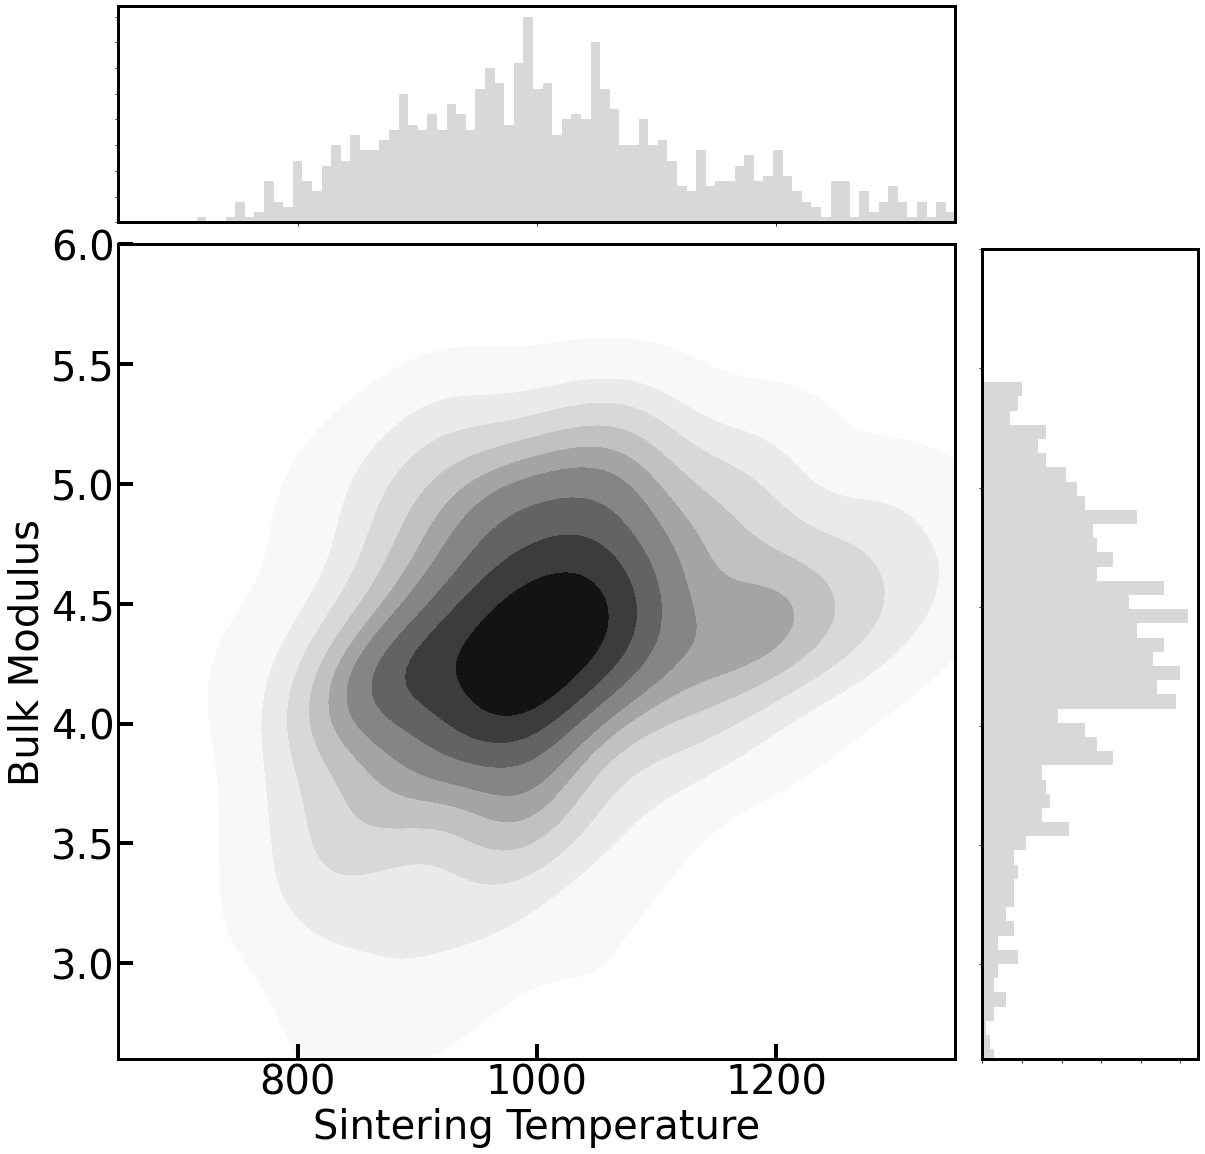

In [120]:
# KDE version
alpha = 1
label_size = 40
tick_label_size = 40
title_size = 60
tick_length = 15
tick_width = 4
xlim = [650, 1350]
ylim  = [2.6, 6]
matplotlib.rcParams['axes.linewidth'] = 3

### 
left, width = 0.125, 0.775
bottom, height = 0.125, 0.75
spacing = 0.025
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

#define figure
fig, ax = plt.subplots()
fig.set_figheight(15) # figure height
fig.set_figwidth(15) # figure width

sns.kdeplot(data=df, x="sinter_random", y="bulk_mod_random", fill = True, cmap = 'Greys', alpha = alpha)
# plt.title('Random', fontsize = title_size)
plt.xlabel('Sintering Temperature', size = label_size)
plt.ylabel('Bulk Modulus', size = label_size)
ax.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
plt.xticks(fontsize = tick_label_size)
plt.yticks(fontsize = tick_label_size)
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)
ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')

fig.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  2.,  2.,  0.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,
         4.,  3.,  5.,  3.,  3.,  0.,  2.,  2.,  2.,  1.,  2.,  3.,  3.,
         1.,  1.,  5.,  5.,  4., 10.,  6.,  6.,  3.,  9.,  6.,  7.,  6.,
         9.,  5., 10., 10., 19., 12., 11., 21., 15., 17., 12., 15., 24.,
        23., 14., 23., 23., 28., 23., 25., 22., 23., 17., 19., 19., 23.,
        18., 24., 31., 17., 22., 22., 30., 39., 23., 17., 22., 31., 17.,
        19., 19., 16., 18., 10., 14.,  2.,  3.,  3.]),
 array([1.00190568, 1.04711138, 1.09231709, 1.1375228 , 1.1827285 ,
        1.22793421, 1.27313991, 1.31834562, 1.36355132, 1.40875703,
        1.45396273, 1.49916844, 1.54437414, 1.58957985, 1.63478555,
        1.67999126, 1.72519696, 1.77040267, 1.81560837, 1.86081408,
        1.90601978, 1.95122549, 1.99643119, 2.0416369 , 2.0868426 ,
        2.13204831, 2.17725401, 2.22245972, 2.26766542, 2.31287113,
        2.35807683, 2.4032

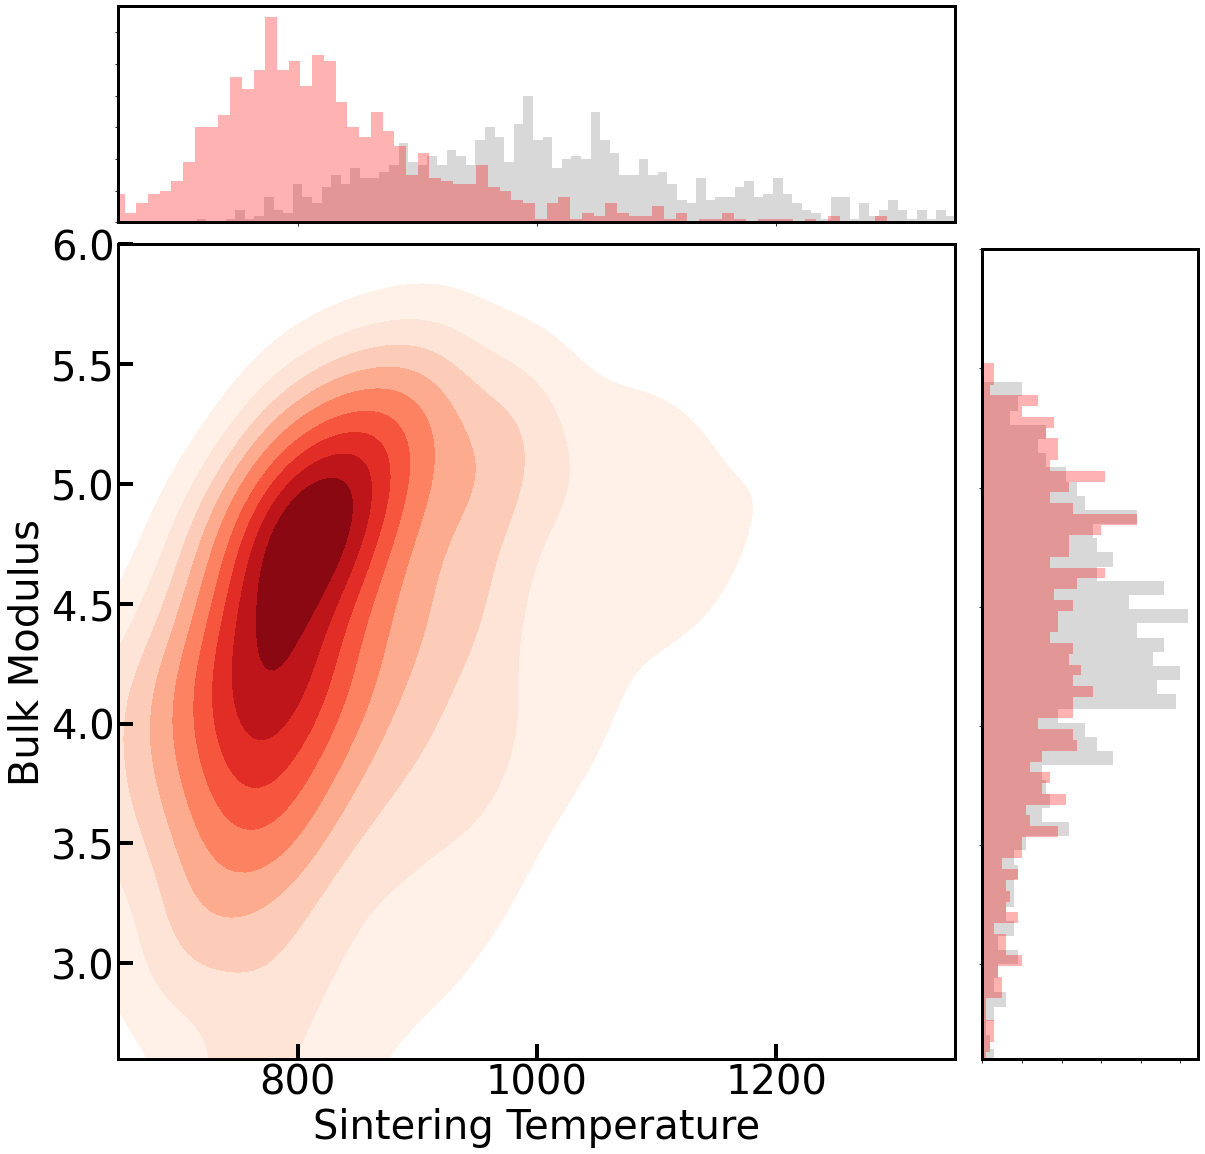

In [121]:
# KDE version
alpha = 1
label_size = 40
tick_label_size = 40
title_size = 60
tick_length = 15
tick_width = 4
xlim = [650, 1350]
ylim  = [2.6, 6]
matplotlib.rcParams['axes.linewidth'] = 3

### 
left, width = 0.125, 0.775
bottom, height = 0.125, 0.75
spacing = 0.025
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

#define figure
fig, ax = plt.subplots()
fig.set_figheight(15) # figure height
fig.set_figwidth(15) # figure width

sns.kdeplot(data=df, x="sinter_1-62", y="bulk_mod_1-62", fill = True, cmap = 'Reds', alpha = alpha)
# plt.title('Random', fontsize = title_size)
plt.xlabel('Sintering Temperature', size = label_size)
plt.ylabel('Bulk Modulus', size = label_size)
ax.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
plt.xticks(fontsize = tick_label_size)
plt.yticks(fontsize = tick_label_size)
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)

ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')
ax_histx.hist(df['sinter_1-62'], color = 'red', alpha = 0.3, bins = bins)
ax_histy.hist(df['bulk_mod_1-62'], color = 'red', alpha = 0.3, bins = bins, orientation='horizontal')

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  2.,  2.,  2.,
         0.,  0.,  0.,  2.,  5.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,
         3.,  7.,  5.,  8.,  7.,  7., 12.,  7.,  4.,  1.,  8.,  3.,  8.,
         7., 12.,  7.,  6.,  4., 12.,  8.,  5., 12., 17.,  9.,  8., 13.,
         9., 19., 11., 15., 11.,  8., 13., 14., 18., 10., 16., 22., 20.,
        18., 20., 21., 27., 34., 32., 33., 38., 35., 49., 43., 41., 21.,
        32., 32., 35., 19., 21., 11., 10.,  5.,  3.]),
 array([1.7815361 , 1.8204488 , 1.8593615 , 1.89827419, 1.93718689,
        1.97609959, 2.01501228, 2.05392498, 2.09283768, 2.13175037,
        2.17066307, 2.20957577, 2.24848846, 2.28740116, 2.32631386,
        2.36522655, 2.40413925, 2.44305195, 2.48196465, 2.52087734,
        2.55979004, 2.59870274, 2.63761543, 2.67652813, 2.71544083,
        2.75435352, 2.79326622, 2.83217892, 2.87109161, 2.91000431,
        2.94891701, 2.9878

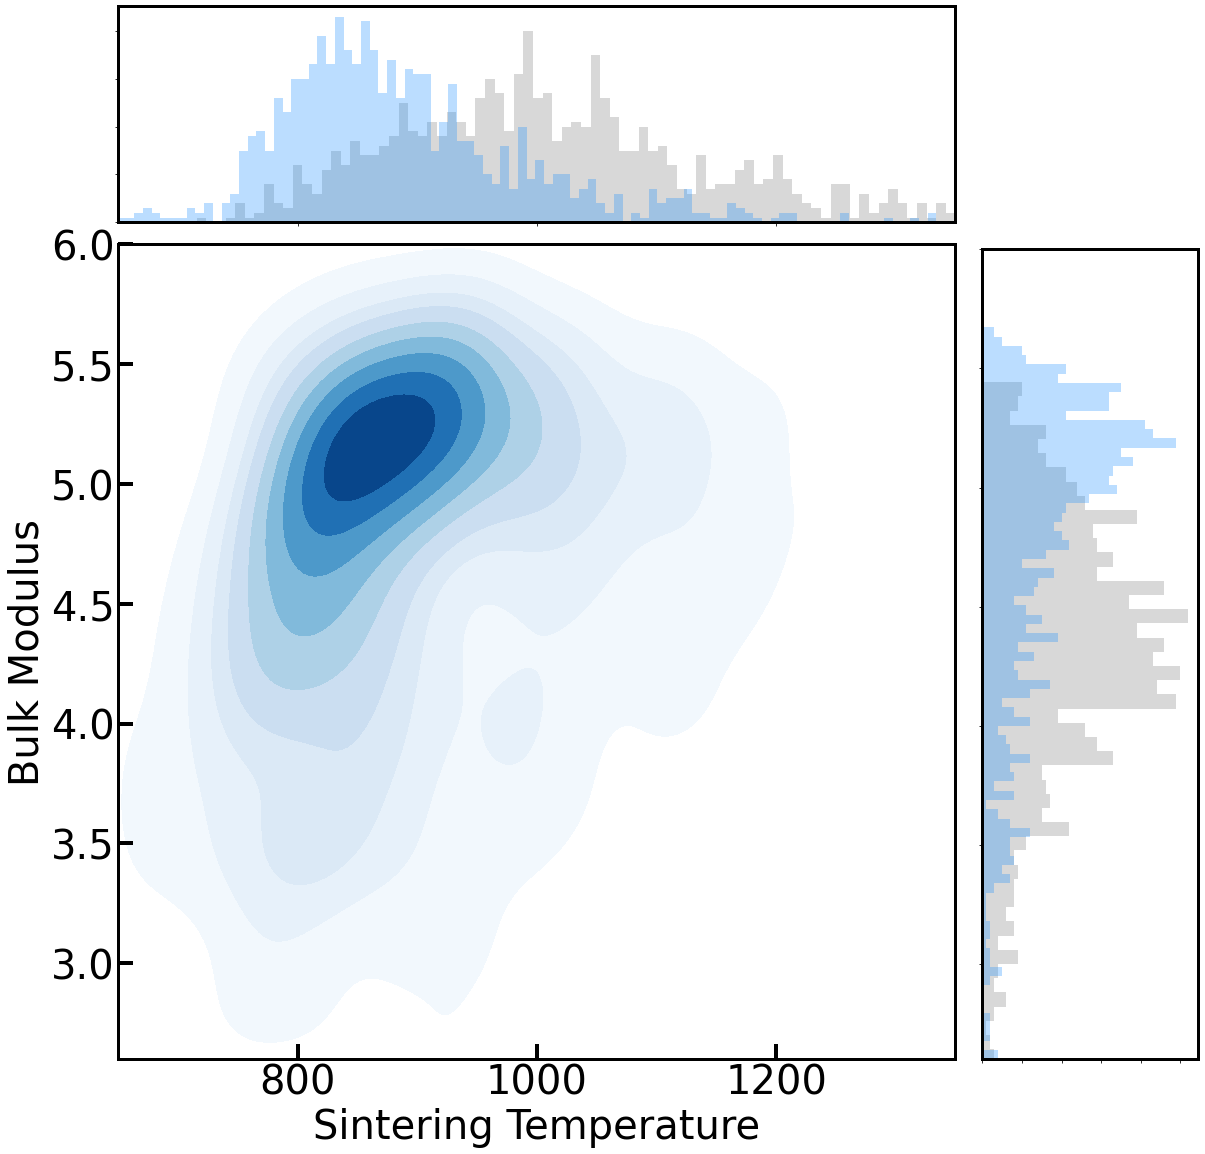

In [123]:
# KDE version
alpha = 1
label_size = 40
tick_label_size = 40
title_size = 60
tick_length = 15
tick_width = 4
xlim = [650, 1350]
ylim  = [2.6, 6]
matplotlib.rcParams['axes.linewidth'] = 3

### 
left, width = 0.125, 0.775
bottom, height = 0.125, 0.75
spacing = 0.025
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

#define figure
fig, ax = plt.subplots()
fig.set_figheight(15) # figure height
fig.set_figwidth(15) # figure width

sns.kdeplot(data=df, x="sinter_1-125", y="bulk_mod_1-125", fill = True, cmap = 'Blues', alpha = alpha)
# plt.title('Random', fontsize = title_size)
plt.xlabel('Sintering Temperature', size = label_size)
plt.ylabel('Bulk Modulus', size = label_size)
ax.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
plt.xticks(fontsize = tick_label_size)
plt.yticks(fontsize = tick_label_size)
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)

ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')
ax_histx.hist(df['sinter_1-125'], color = 'dodgerblue', alpha = 0.3, bins = bins)
ax_histy.hist(df['bulk_mod_1-125'], color = 'dodgerblue', alpha = 0.3, bins = bins, orientation='horizontal')

(array([  1.,   1.,   0.,   1.,   0.,   2.,   0.,   1.,   2.,   0.,   1.,
          0.,   0.,   3.,   3.,   0.,   0.,   2.,   2.,   2.,   3.,   1.,
          1.,   4.,   0.,   1.,   4.,   4.,   3.,   3.,   7.,   5.,  12.,
          9.,  11.,  20.,  23.,  31.,  41.,  46.,  75.,  97., 121., 144.,
        110.,  91.,  64.,  33.,  13.,   2.]),
 array([2.80436134, 2.86317451, 2.92198769, 2.98080086, 3.03961403,
        3.0984272 , 3.15724037, 3.21605354, 3.27486671, 3.33367989,
        3.39249306, 3.45130623, 3.5101194 , 3.56893257, 3.62774574,
        3.68655891, 3.74537209, 3.80418526, 3.86299843, 3.9218116 ,
        3.98062477, 4.03943794, 4.09825111, 4.15706429, 4.21587746,
        4.27469063, 4.3335038 , 4.39231697, 4.45113014, 4.50994331,
        4.56875648, 4.62756966, 4.68638283, 4.745196  , 4.80400917,
        4.86282234, 4.92163551, 4.98044868, 5.03926186, 5.09807503,
        5.1568882 , 5.21570137, 5.27451454, 5.33332771, 5.39214088,
        5.45095406, 5.50976723, 5.5685804 , 5.

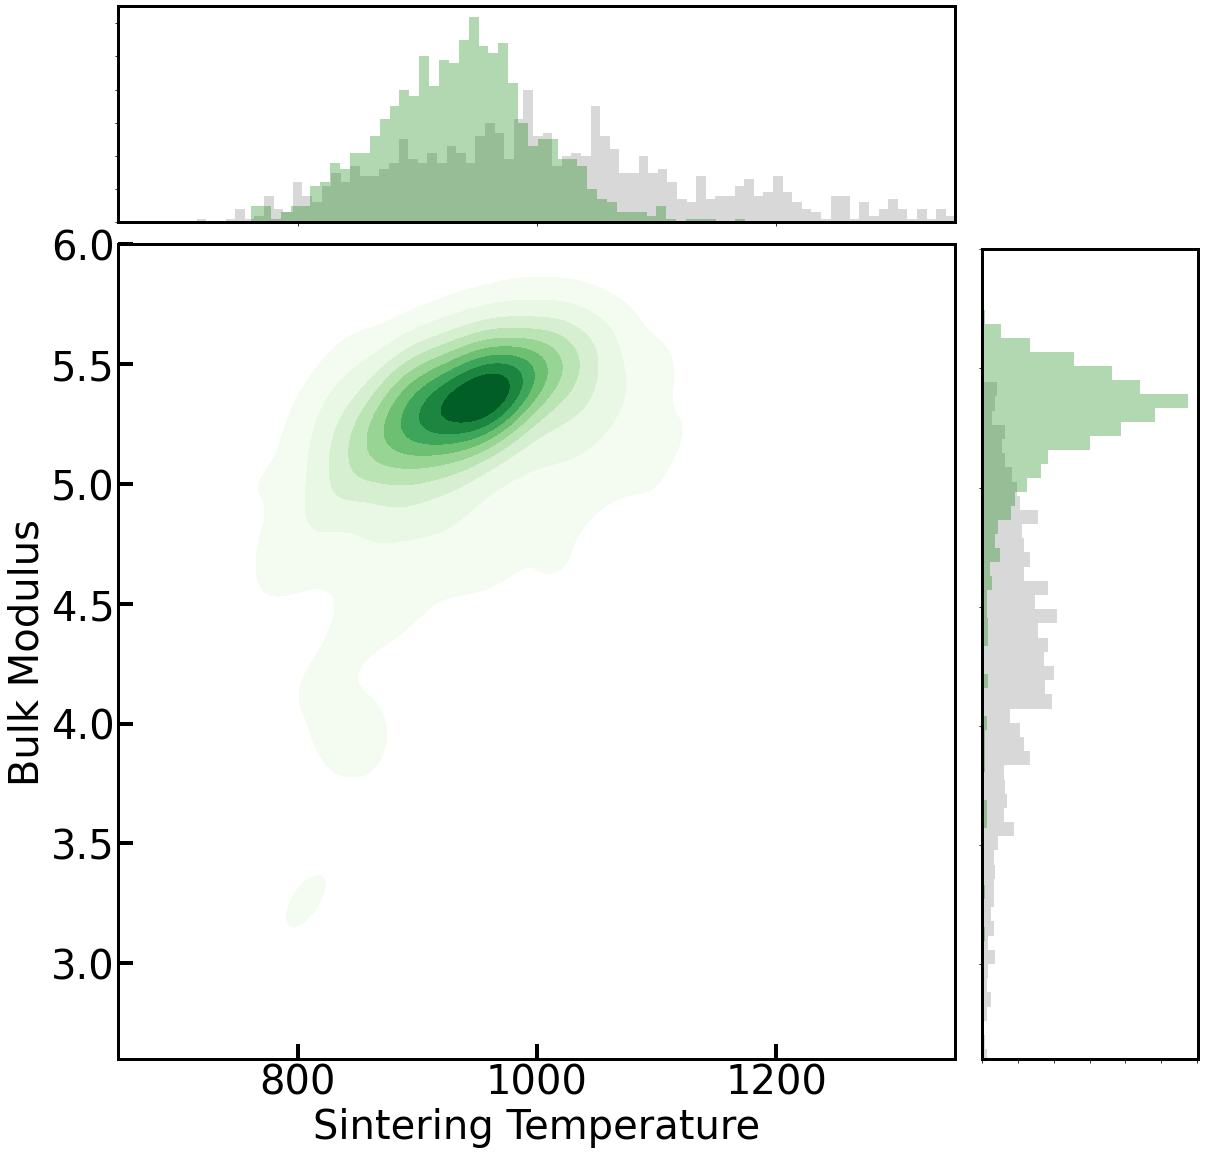

In [122]:
# KDE version
alpha = 1
label_size = 40
tick_label_size = 40
title_size = 60
tick_length = 15
tick_width = 4
xlim = [650, 1350]
ylim  = [2.6, 6]
matplotlib.rcParams['axes.linewidth'] = 3

### 
left, width = 0.125, 0.775
bottom, height = 0.125, 0.75
spacing = 0.025
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

#define figure
fig, ax = plt.subplots()
fig.set_figheight(15) # figure height
fig.set_figwidth(15) # figure width

sns.kdeplot(data=df, x="sinter_1-250", y="bulk_mod_1-250", fill = True, cmap = 'Greens', alpha = alpha)
# plt.title('Random', fontsize = title_size)
plt.xlabel('Sintering Temperature', size = label_size)
plt.ylabel('Bulk Modulus', size = label_size)
ax.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
plt.xticks(fontsize = tick_label_size)
plt.yticks(fontsize = tick_label_size)
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

# # Os5WO5$
# plt.plot([880.6949242424243], [5.514501571655273], marker = '*', markersize = 75, color = 'green', 
#                                                                 markeredgewidth = 5, markeredgecolor = 'black')
# plt.text(700, 5.7, 'Os$_5$WO$_5$', fontsize = 40)

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)

ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')
ax_histx.hist(df['sinter_1-250'], color = 'g', alpha = 0.3, bins = 50)
ax_histy.hist(df['bulk_mod_1-250'], color = 'g', alpha = 0.3, bins = 50, orientation='horizontal')

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  4.,  2.,  4.,
         0.,  2.,  7.,  3.,  4.,  2.,  4., 12., 15., 19., 11.,  9., 11.,
        19., 13., 16., 13., 29., 17., 22., 30., 26., 21., 32., 26., 42.,
        38., 48., 66., 71., 84., 84., 53., 67., 40., 21.,  8.]),
 array([1.7815361 , 1.8593615 , 1.93718689, 2.01501228, 2.09283768,
        2.17066307, 2.24848846, 2.32631386, 2.40413925, 2.48196465,
        2.55979004, 2.63761543, 2.71544083, 2.79326622, 2.87109161,
        2.94891701, 3.0267424 , 3.10456779, 3.18239319, 3.26021858,
        3.33804398, 3.41586937, 3.49369476, 3.57152016, 3.64934555,
        3.72717094, 3.80499634, 3.88282173, 3.96064713, 4.03847252,
        4.11629791, 4.19412331, 4.2719487 , 4.34977409, 4.42759949,
        4.50542488, 4.58325027, 4.66107567, 4.73890106, 4.81672646,
        4.89455185, 4.97237724, 5.05020264, 5.12802803, 5.20585342,
        5.28367882, 5.36150421, 5.43932961, 5.517155  , 5.59498039,
        5.67280579]),
 <BarContainer

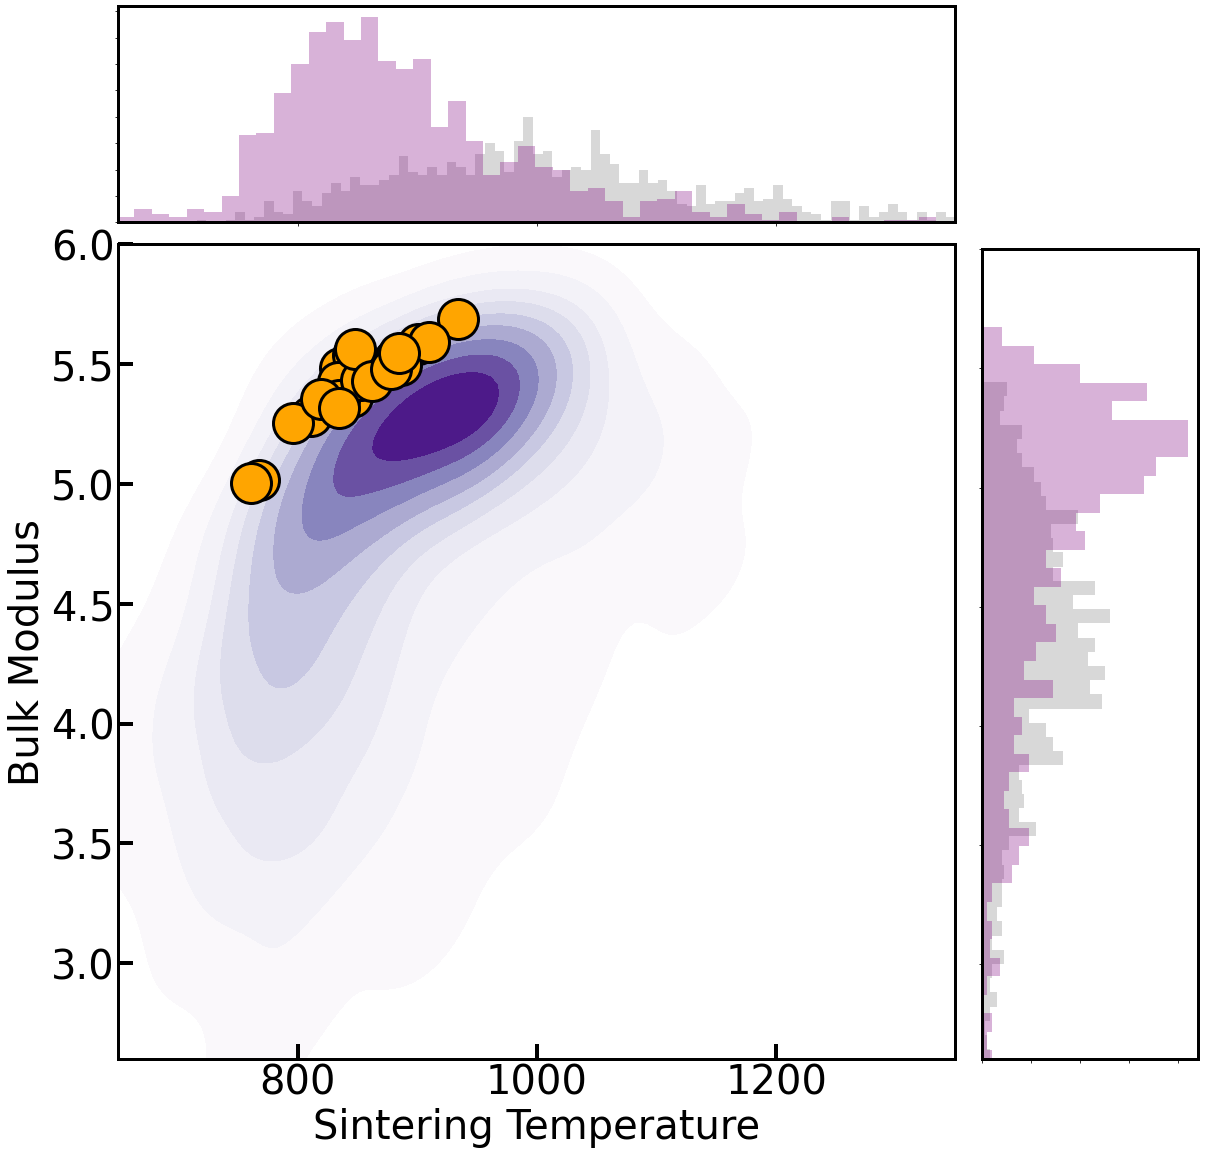

In [165]:
# combined KDE of all three lambda 
DQN_points = pd.concat([df[['sinter_1-250', 'bulk_mod_1-250']].rename(columns = {'sinter_1-250': 'sinter', 'bulk_mod_1-250': 'bulk_mod'}),
                        df[['sinter_1-125', 'bulk_mod_1-125']].rename(columns = {'sinter_1-125': 'sinter', 'bulk_mod_1-125': 'bulk_mod'}),
                        df[['sinter_1-62', 'bulk_mod_1-62']].rename(columns = {'sinter_1-62': 'sinter', 'bulk_mod_1-62': 'bulk_mod'}),
                        ]).reset_index()
# individual points of pareto compounds - list of (x, y) tuples
pareto_coordinates = [(880.6949242424243, 5.514501571655273), (900.6782575757576, 5.583494186401367), (834.979901956596, 5.481292724609375), (846.6589096320345, 5.411442756652832), (833.0226001082251, 5.4043097496032715), (845.5908739177488, 5.3612751960754395), (767.6424999999998, 5.014556884765625), (846.21125, 5.535493850708008), (834.021498917749, 5.423008441925049), (811.1791220238097, 5.281761169433594), (834.2172429653681, 5.347630500793457), (852.5281250000002, 5.433277606964111), (881.393593073593, 5.521707534790039), (886.6706809701491, 5.513875484466553), (795.6465151515152, 5.254571914672852), (819.4177489177488, 5.353219985961914), (834.4576822866188, 5.315943717956543), (933.5936417748919, 5.685741424560547), (847.6270138888888, 5.5605854988098145), (886.1350694444445, 5.495654106140137), (862.155902777778, 5.426607608795166), (909.9727678571429, 5.592461585998535), (878.0120833333334, 5.476545333862305), (884.9522916666667, 5.543166160583496), (761.0118749999998, 5.001378536224365)]

# KDE version
alpha = 1
label_size = 40
tick_label_size = 40
title_size = 60
tick_length = 15
tick_width = 4
xlim = [650, 1350]
ylim  = [2.6, 6]
matplotlib.rcParams['axes.linewidth'] = 3

### 
left, width = 0.125, 0.775
bottom, height = 0.125, 0.75
spacing = 0.025
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

#define figure
fig, ax = plt.subplots()
fig.set_figheight(15) # figure height
fig.set_figwidth(15) # figure width

sns.kdeplot(data=DQN_points, x="sinter", y="bulk_mod", fill = True, cmap = 'Purples', alpha = alpha)
# plt.title('Random', fontsize = title_size)
plt.xlabel('Sintering Temperature', size = label_size)
plt.ylabel('Bulk Modulus', size = label_size)
ax.tick_params(axis='x', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
ax.tick_params(axis='y', labelsize= tick_label_size, length = tick_length, width = tick_width, direction = 'in')
plt.xticks(fontsize = tick_label_size)
plt.yticks(fontsize = tick_label_size)
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

for x, y in pareto_coordinates:
    plt.plot(x, y, marker = 'o', markersize = 40, color = 'orange', 
                                                                markeredgewidth = 3, markeredgecolor = 'black')
    

# # Os5WO5$
# plt.plot([880.6949242424243], [5.514501571655273], marker = '*', markersize = 40, color = 'green', 
#                                                                 markeredgewidth = 5, markeredgecolor = 'black')
# plt.text(700, 5.7, 'Os$_5$WO$_5$', fontsize = 40)

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)

ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')
ax_histx.hist(DQN_points['sinter'].iloc[1000:len(sinter_random)+1000], color = 'purple', alpha = 0.3, bins = 50)
ax_histy.hist(DQN_points['bulk_mod'].iloc[1000:len(bulk_mod_random)+1000], color = 'purple', alpha = 0.3, bins = 50, orientation='horizontal')

In [140]:
DQN_points = pd.concat([df[['sinter_1-250', 'bulk_mod_1-250']].rename(columns = {'sinter_1-250': 'sinter', 'bulk_mod_1-250': 'bulk_mod'}),
                        df[['sinter_1-125', 'bulk_mod_1-125']].rename(columns = {'sinter_1-125': 'sinter', 'bulk_mod_1-125': 'bulk_mod'}),
                        df[['sinter_1-62', 'bulk_mod_1-62']].rename(columns = {'sinter_1-62': 'sinter', 'bulk_mod_1-62': 'bulk_mod'}),
                        ]).reset_index()
DQN_points

,index,sinter,bulk_mod
0,0,969.837143,5.374899
1,1,934.047205,5.213277
2,2,1048.720060,5.334540
3,3,962.808185,5.413830
4,4,931.505915,5.270806
...,...,...,...
2995,995,739.302033,4.230743
2996,996,984.131374,4.715594
2997,997,1054.486265,2.992527
2998,998,718.490208,4.282862


In [136]:
df

,sinter_random,bulk_mod_random,sinter_1-250,bulk_mod_1-250,sinter_1-125,bulk_mod_1-125,sinter_1-62,bulk_mod_1-62
0,1078.504167,4.564713,969.837143,5.374899,784.019792,4.130368,861.910000,4.109288
1,848.222500,4.202143,934.047205,5.213277,1113.102711,5.107035,920.769389,4.522017
2,985.951161,4.978990,1048.720060,5.334540,968.534080,5.460206,861.865322,4.939682
3,1055.274982,4.433240,962.808185,5.413830,1156.977237,4.675231,731.903333,3.680496
4,1079.890736,4.932131,931.505915,5.270806,844.064801,5.050420,738.660529,4.770070
...,...,...,...,...,...,...,...,...
995,1076.455089,3.671948,890.837525,4.965373,754.308168,4.414021,739.302033,4.230743
996,1134.098367,4.961004,864.308910,5.273553,827.214008,4.870847,984.131374,4.715594
997,1095.133479,4.143021,947.631499,5.505041,1141.706695,4.962703,1054.486265,2.992527
998,1191.093996,4.960401,921.411935,5.482382,931.969619,5.167592,718.490208,4.282862
